In [1]:
import dask_ml
dask_ml.__file__

'/Users/scott/Developer/stsievert/dask-ml/dask_ml/__init__.py'

In [2]:
from distributed import Client
client = Client()
client

/Users/scott/anaconda3/lib/python3.6/site-packages/distributed/utils.py:136: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 51] Network is unreachable
  RuntimeWarning,


Client Scheduler: tcp://127.0.0.1:53130 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


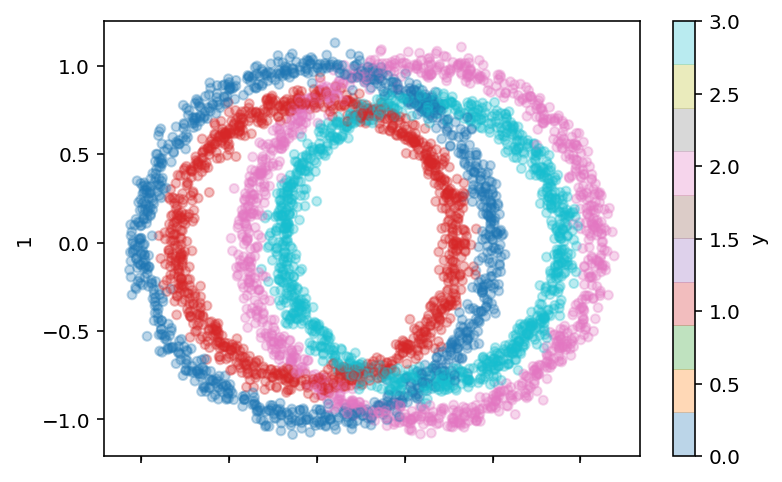

In [3]:
from sklearn.datasets import make_circles
import numpy as np
import pandas as pd

X1, y1 = make_circles(n_samples=30_000, random_state=0, noise=0.04)
X2, y2 = make_circles(n_samples=30_000, random_state=1, noise=0.04)
X2[:, 0] += 0.6
X_info = np.concatenate((X1, X2))
y = np.concatenate((y1, y2 + 2))

df = pd.DataFrame(X_info)
df["y"] = y
df.sample(4_000).plot.scatter(x=0, y=1, c="y", cmap="tab10", alpha=0.3)


In [4]:
# add random features

from sklearn.preprocessing import PolynomialFeatures

random_feats = np.random.uniform(-1, 1, size=(X_info.shape[0], 4))
X_ = np.hstack((X_info, random_feats))

X = X_
# transform = PolynomialFeatures(degree=4)
# X = transform.fit_transform(X_)
X.shape

(60000, 6)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10_000, random_state=42)

In [6]:
import numpy as np
assert np.unique(y).tolist() == [0, 1, 2, 3]

In [7]:
X_test.shape

(10000, 6)

Let's normalize the data as in https://github.com/zalandoresearch/fashion-mnist/blob/629abc0f9a73c2897383a9178e8e38f7141be30d/benchmark/runner.py#L40-L44

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
from dask_ml.model_selection import HyperbandSearchCV

/Users/scott/anaconda3/lib/python3.6/site-packages/numba/errors.py:102: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [10]:
import numpy as np
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()

params = {
    "hidden_layer_sizes": [(20, ), (10, ) * 2, (5, ) * 4],  # 3
    "alpha": np.logspace(-6, -3, num=1000),  # cnts
    "batch_size": [32, 64, 128, 256, 512],  # 5
    "learning_rate": ["constant", "invscaling"],
    "learning_rate_init": np.logspace(-4, -2, num=1000), # cnts
    "power_t": np.linspace(0.1, 0.9, num=1000), # cnts
    "momentum": np.linspace(0, 1, num=1000),  # cnts
    "nesterovs_momentum": [True],  # 1
    "n_iter_no_change": [np.inf],
    "solver": ["sgd"],
    "activation": ["relu"],
}

This is `1 * 6 * 3 = 18` discrete combinations. There are 2 or 3 continious variables to tune.

In [11]:
X_train.shape, y_train.shape

((50000, 6), (50000,))

Let's train for 30 epochs and sample 180 parameters (10 parameters for every discrete combo). According to the documentation, that means each chunk should be 1/6 of the dataset.

In [27]:
epochs = 81
n_params = 230

n = len(X_train)
max_iter = n_params
chunks = epochs * n // n_params
max_iter, chunks

(230, 17608)

In [28]:
from dask_ml.model_selection import train_test_split
import dask.array as da
X_train = da.from_array(X_train, chunks=chunks)
y_train = da.from_array(y_train, chunks=chunks)
X_train

dask.array<array, shape=(50000, 6), dtype=float64, chunksize=(17608, 6)>

In [30]:
X_train.chunks

((17608, 17608, 14784), (6,))

In [31]:
classes = da.unique(y_train).compute()
print(classes)
y_train

[0 1 2 3]


dask.array<array, shape=(50000,), dtype=int64, chunksize=(17608,)>

In [32]:
def fit_hyperband(model, params, max_iter=None, random_state=None):
    search = HyperbandSearchCV(
        model,
        params,
        max_iter=max_iter,
        random_state=random_state,
    )

    search.fit(X_train, y_train, classes=classes)
    assert pd.DataFrame(search.history_)["partial_fit_calls"].max() == max_iter
    return search

N = 10
searches = {"hyperband": [], "passive": []}

In [33]:
from time import time
for k in range(N):
    print(f"Starting {k}...", end="")
    start = time()
    search = fit_hyperband(model, params, max_iter=max_iter, random_state=k)
    print(f"   done in {time() - start:2f} seconds")
    searches["hyperband"].append(search)

Starting 0...   done in 360.392112 seconds
Starting 1...   done in 221.348260 seconds
Starting 2...   done in 325.629016 seconds
Starting 3...   done in 230.886178 seconds
Starting 4...   done in 216.061586 seconds
Starting 5...   done in 219.710902 seconds
Starting 6...   done in 214.426427 seconds
Starting 7...   done in 202.060854 seconds
Starting 8...   done in 189.344998 seconds
Starting 9...   done in 178.885499 seconds


In [34]:
total_calls = searches["hyperband"][0].metadata["partial_fit_calls"]

# total_calls = n_init * one_model
# set n_init = calls / one_model
n_init = total_calls / max_iter
total_calls, n_init

(4167, 18.117391304347827)

In [35]:
from dask_ml.model_selection import IncrementalSearchCV

def fit_passive(model, params, n_initial_params=None, max_iter=None, random_state=None):
    passive = IncrementalSearchCV(
        model,
        params,
        decay_rate=0,
        n_initial_parameters=n_init,
        max_iter=max_iter,
        random_state=random_state,
    )

    passive.fit(X_train, y_train, classes=classes)
    assert pd.DataFrame(passive.history_)["partial_fit_calls"].max() == max_iter
    return passive

In [36]:
for k in range(N):
    print(f"Starting {k}...", end="")
    start = time()
    search = fit_passive(
        model,
        params,
        max_iter=max_iter,
        n_initial_params=n_init,
        random_state=k
    )
    print(f"   done in {time() - start:2f} seconds")
    searches["passive"].append(search)

Starting 0...   done in 237.434647 seconds
Starting 1...   done in 177.743736 seconds
Starting 2...   done in 222.351134 seconds
Starting 3...   done in 260.747534 seconds
Starting 4...   done in 295.167698 seconds
Starting 5...   done in 384.778039 seconds
Starting 6...   done in 242.751284 seconds
Starting 7...   done in 239.903744 seconds
Starting 8...   done in 318.968819 seconds
Starting 9...   done in 247.018728 seconds


In [44]:
import msgpack
today = "2019-06-20"

def _get_history(search):
    params = {k: v for k, v in search.get_params().items()
              if "estimator" not in k and k != "parameters"
    }
    out = [{**params, **h} for h in search.history_]
    return out

histories = {k: [_get_history(search) for search in alg_searches] for k, alg_searches in searches.items()}
with open(f"out/{today}-histories-2.msgpack", "wb") as f:
    msgpack.dump(histories, f)

best_scores = [
    {"score": search.best_score_, "alg": alg}
    for alg, alg_searches in searches.items()
    for search in alg_searches
]

params = [
    {"alg": alg, **search.best_params_}
    for alg, alg_searches in searches.items()
    for search in alg_searches
]

pd.DataFrame(best_scores).to_csv(f"out/{today}-best-scores.csv", index=False)
pd.DataFrame(params).to_csv(f"out/{today}-best-params.csv", index=False)

In [21]:
def shape_history(history, **kwargs):
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    start = history[0]["elapsed_wall_time"]
    for row in history:
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 **kwargs}]
    return out

In [25]:
import pandas as pd

histories = [
    shape_history(search.history_, alg=alg_name, random_state=search.random_state)
    for alg_name, alg_searches in searches.items()
    for search in alg_searches
]

df = pd.DataFrame(sum(histories, []))
df.head(n=2)

,alg,best_score,cumulative_partial_fit_calls,elapsed_wall_time,random_state
0,hyperband,0.2843,1,0.000000,0
1,hyperband,0.2843,2,0.000003,0


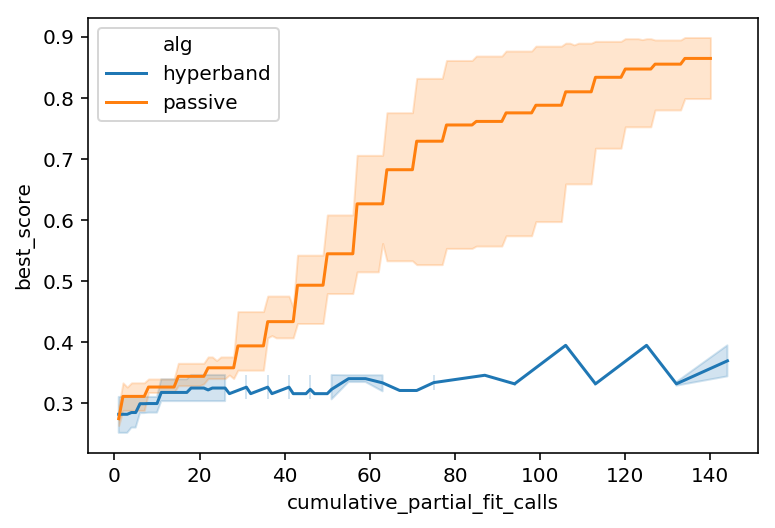

In [27]:
import seaborn as sns
ax = sns.lineplot(
    data=df,
    x="cumulative_partial_fit_calls",
    y="best_score",
    hue="alg",
)
# ax.set_ylim(0.5, None)

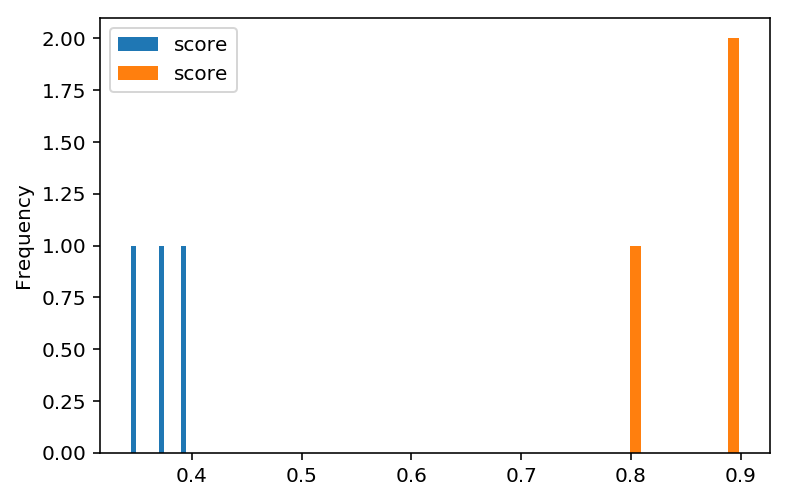

In [41]:
import matplotlib.pyplot as plt
best_scores = [
    {"score": search.best_score_, "alg": alg}
    for alg, alg_searches in searches.items()
    for search in alg_searches
]

show = pd.DataFrame(best_scores)
fig, ax = plt.subplots()
for alg in show.alg.unique():
    show[show.alg == alg].plot.hist(ax=ax, label=alg)

In [48]:
params = [
    {"alg": alg, **search.best_params_}
    for alg, alg_searches in searches.items()
    for search in alg_searches
]

params = pd.DataFrame(params)
params.drop(
    columns=[
        "n_iter_no_change",
        "activation",
        "nesterovs_momentum",
        "solver"
    ], inplace=True
)
params

,alg,alpha,batch_size,hidden_layer_sizes,learning_rate,learning_rate_init,momentum,power_t
0,hyperband,0.000015,64,"(20,)",constant,0.000621,0.900901,0.829530
1,hyperband,0.000032,512,"(20,)",constant,0.000309,0.981982,0.587688
2,hyperband,0.000047,32,"(20,)",constant,0.002395,0.251251,0.243343
3,passive,0.000176,64,"(10, 10)",constant,0.004962,0.836837,0.284985
4,passive,0.000176,64,"(10, 10)",constant,0.004962,0.836837,0.284985
5,passive,0.000176,64,"(10, 10)",constant,0.004962,0.836837,0.284985
